# Sensitivity analysis

In [26]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [27]:
dataset = "iris"
def_g = 5
def_dt = 0.4

In [28]:
# dataset = "flame"
# def_g = 9
# def_dt = 0.5

In [29]:
results = pickle.load(open("results_exp/"+dataset+"_vd.p", "rb"))

In [30]:
results.keys()

dict_keys(['hp', 'precisions', 'coverages', 'dist exp', 'empty VDs', 'mdos'])

In [31]:
mean_precs = np.mean(results['precisions'],axis=1)
mean_cov = np.mean(results['coverages'],axis=1)
mean_mdo = np.mean(results['mdos'],axis=1)
std_precs = np.std(results['precisions'],axis=1)
std_cov = np.std(results['coverages'],axis=1)
std_mdo = np.std(results['mdos'],axis=1)

Distance threshold

In [32]:
idx_def_g = np.where(np.asarray(results['hp'])[:,0]==def_g)

In [33]:
dt = np.asarray(results['hp'])[:,1][idx_def_g]

In [34]:
dt

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

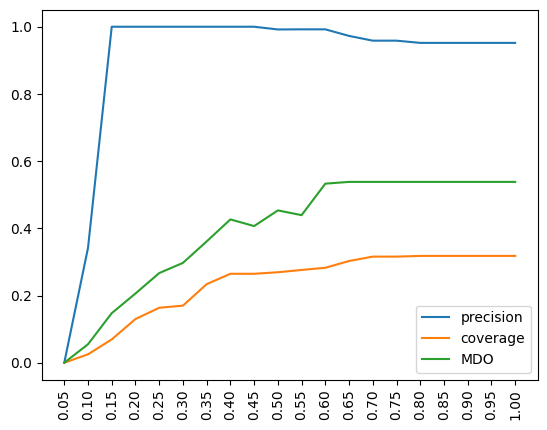

In [35]:
plt.figure()
plt.plot(dt, mean_precs[idx_def_g], label="precision")
plt.plot(dt, mean_cov[idx_def_g], label="coverage")
plt.plot(dt, mean_mdo[idx_def_g], label="MDO")
plt.xticks(dt, rotation='vertical')
# plt.yticks(dt)
plt.legend()
plt.show()

In [36]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name='Precision',
        x=dt,
        y=mean_precs[idx_def_g],
        error_y=dict(
            type='data',
            array=std_precs[idx_def_g],
            visible=True)
    ))
fig.add_trace(
    go.Scatter(
        name='Coverage',
        x=dt,
        y=mean_cov[idx_def_g],
        error_y=dict(
            type='data',
            array=std_cov[idx_def_g],
            visible=True)
    ))
fig.add_trace(
    go.Scatter(
        name='MDO',
        x=dt,
        y=mean_mdo[idx_def_g],
        error_y=dict(
            type='data',
            array=std_mdo[idx_def_g],
            visible=True)
    ))
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.05,
        dtick = 0.05
    )

)
fig.update_layout(
    xaxis_title="Distance threshold",
    yaxis_title="Scores",
    legend_title="Measures",
    # font=dict(
    #     family="Courier New, monospace",
    #     size=18,
    #     color="RebeccaPurple"
    # )
)
fig.show()

Gamma

In [37]:
idx_def_dt = np.where(np.asarray(results['hp'])[:,1]==def_dt)

In [38]:
g = np.asarray(results['hp'])[:,0][idx_def_dt]

In [39]:
g

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

In [40]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name='Precision',
        x=g,
        y=mean_precs[idx_def_dt],
        error_y=dict(
            type='data',
            array=std_precs[idx_def_dt],
            visible=True)
    ))
fig.add_trace(
    go.Scatter(
        name='Coverage',
        x=g,
        y=mean_cov[idx_def_dt],
        error_y=dict(
            type='data',
            array=std_cov[idx_def_dt],
            visible=True)
    ))
fig.add_trace(
    go.Scatter(
        name='MDO',
        x=g,
        y=mean_mdo[idx_def_dt],
        error_y=dict(
            type='data',
            array=std_mdo[idx_def_dt],
            visible=True)
    ))
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    )

)
fig.update_layout(
    xaxis_title="Gamma",
    yaxis_title="Scores",
    legend_title="Measures",
    # font=dict(
    #     family="Courier New, monospace",
    #     size=18,
    #     color="RebeccaPurple"
    # )
)
fig.show()

SVM F1

In [41]:
from utils import load_dataset, train_model
import os
import shap
from sklearn.metrics import pairwise_distances, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

In [42]:
X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)

In [43]:
model = train_model(X_train, y_train, model_name="m0")
print(model.score(X, y))
print(model.score(X_test, y_test))

0.98
0.9666666666666667


In [44]:
path = "results_exp/shap_values/"+dataset+".p"
if os.path.isfile(path):
    print("Getting explanations")
    shap_values = pickle.load(open(path, "rb"))
else:
    print("Producing explanations")
    explainer = shap.Explainer(model.predict,X_train,feature_names=feature_names)
    shap_values = explainer(X_train)

    shap_values = np.asarray(shap_values.values)
    pickle.dump(shap_values, open(path, "wb"))

Getting explanations


In [45]:
scaler = MinMaxScaler()
y_pred = model.predict(X_train)
dists_exp = {c : scaler.fit_transform(pairwise_distances(shap_values[np.where(y_pred==c)], metric="euclidean")) for c in np.unique(y)}

In [46]:
VD = {c : np.asarray(dists_exp[c]<def_dt).astype(int) for c in np.unique(y)}
y_pred = model.predict(X_train)
pred_idx = {c : np.where(y_pred==c) for c in np.unique(y)}

In [47]:
y_pred

array([0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2,
       1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2, 2,
       1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 2, 2, 1,
       0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2,
       1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2,
       1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [48]:
mean_precs = []
mean_recalls = []
std_precs = []
std_recalls = []
for gamma in g:
    models_VD = []
    precs = []
    recalls = []
    for i in np.arange(len(X_train)):
        c = y_pred[i]
        X_train_c = X_train[pred_idx[c]]
        VD_c = VD[c]
        idx_vd = np.where(pred_idx[c]==i)[0][0]
        m = OneClassSVM(nu=0.01,gamma=gamma).fit(X_train_c[np.where(VD_c[idx_vd])])

        y_m_true = VD_c[idx_vd]
        y_m_pred = np.asarray(m.predict(X_train_c)==1).astype(int)

        prec, recall, f1, supp = precision_recall_fscore_support(y_m_true, y_m_pred)
        models_VD.append(m)
        precs.append(prec)
        recalls.append(recall)
    mean_precs.append(np.mean(precs))
    mean_recalls.append(np.mean(recalls))
    std_precs.append(np.std(precs))
    std_recalls.append(np.std(recalls))

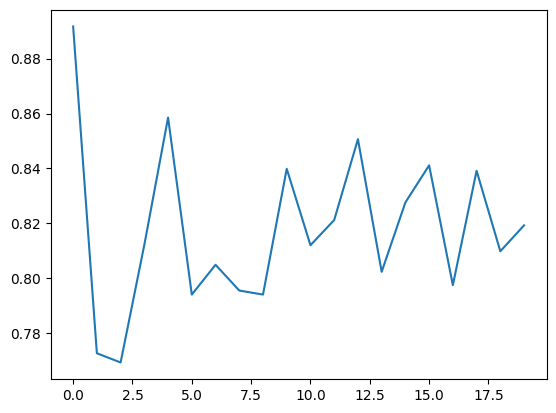

In [49]:
plt.plot(mean_precs)

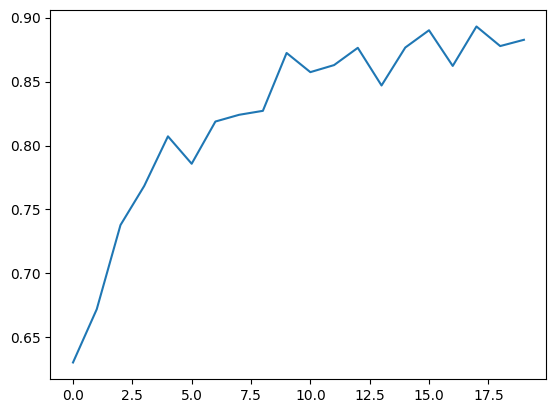

In [50]:
plt.plot(mean_recalls)